# The Fast, Ugly, Solar Geometry and Radiation Model

#### This model incorporates the bare minimum work needed to play around with Earth-Sun geometry and determine how latitude affects solar positioning and receipt of radiation at a surface. Let's build on it as we go.

These are the parameters you can adjust for the model. Note anything too close to the arctic circles will probably break something:

In [6]:
latitude <- 48 # site latitude in degrees. 48 ~= Freiburg (positive N, negative S). Stay away from the poles :/

timestep <- 30 # model timestep in minutes. Try to pick something cleanly divisible with the number of
               # minutes in a day. Smaller timestep will make the solar angle plots make a lot more sense.
               # Good choices: 4, 8, 15, 30, 60

Io <- 1361 # solar constant. 1361 is realistic, but go nuts

startday <- 1 # YD to begin model. Anywhere from 1 to 365 will work

ndays <- 365 # number of steps to run. Try not to go over 365 total days because something will probably break.
             # i.e. if you start on day 100, only run 265 ndays. The model runs from startday:ndays.

Here's the model: feel free to play around with anything you like and see what happens. It will throw you a lot of errors due to something in the azimuth calculation but I brute-force my way around it and it should come out okay:

In [7]:
######
# Procrastination in the form of solar modelling
######

library(tidyr)
library(ggplot2)

#####
# For each day we
# 1. calculate fractional year and solar declination
# 2. calculate solar constant due to orbital effects
# 3. For each time step: calculate solar zenith (elevation) and azimuth
# 4. Calculate irradiance on a flat surface or slope
# 5. keep track of our data for plotting/analysis later

#####
# because we aren't concerned about specific times we assume we're always on local solar time
# and just count minutes in to the day

##### 
# The big list of assumptions:
# 1. atmospheric transmission = 1, weather = 0
# 2. perfectly horizontal surface with
# 3. no horizon obstructions or anything like that
# 4. no atmosphere (no diffuse solar rad)

#####
# TODOs
# 2. implement the slope functions

#####
# FUNCTIONS
#####

# simple functions
radToDeg <- function(r) {return(r * (180/pi))}
degToRad <- function(deg) {return(deg*(pi/180))}


# sun location
fractionalYear <- function(yd) {return((2*pi)/365 * (yd-1))} # gamma, returned in RADIANS

solarDeclination <- function(gamma) { # delta / solar declination
  delta <- 0.006918 - 0.399912*cos(gamma) + 0.070257*sin(gamma) - 
    0.006758*cos(2*gamma) + 0.000907*sin(2*gamma) - 
    0.002697*cos(3*gamma) + 0.00148*sin(3*gamma)
  return(delta) # returned in radians!
}

EqnofTime <- function(gamma) { # equation of time IN MINUTES
  dTlat <- 229.18 * (0.000075 + 0.001868*cos(gamma) -
                       0.032077*sin(gamma) - 0.014615*cos(2*gamma)-
                       0.040849*sin(2*gamma))
  return(dTlat) # returned in MINUTES!
}

hourAngle <- function(minutes) { # simplified hour angle calculation assuming we're always in local solar time
  return(degToRad((1*(minutes-720))/4)) # returned IN RADIANS
}

solarElevation <- function(latitudeRadians, declination, hourAngle) { # determine solar elevation
  # assumes all input variables are already in radians
  elevation <- asin(sin(declination)*sin(latitudeRadians)+cos(declination)*cos(latitudeRadians)*cos(hourAngle))
  return(radToDeg(elevation)) # returned IN DEGREES
}

solarZenith <- function(elevation) { # returns solar zenith in degrees, requires elevation be passed in degrees
  return(90-elevation)
}

solarAzimuth <- function(latitudeRadians, declination, hourAngle, elevationRadians) { # returns solar azimuth
  # assumes all input variables are already in radians
  azimuth <- acos( (sin(declination)*cos(latitudeRadians)-cos(declination)*sin(latitudeRadians)*cos(hourAngle))/cos(elevationRadians) )
  
  if (hourAngle > 0) { # past noon we do 360-azimuth
    az <- 360-radToDeg(azimuth)
  } else {
    az <- radToDeg(azimuth) # returned IN DEGREES
  }
  
  if (is.nan(az)) { # handling errors I don't understand. Something breaks on certain days when az approaches 180
                    # but I don't know what...
    az <- 180
  }
  
  return(az)
}

slopeGeometry <- function(slopeAngleRad, solarElevRad, solarAzRad, slopeAzRad) {# implementing slopes
  # all input variables need to be in radians, lads
  relativeAngle <- acos( cos(slopeAngleRad)*sin(solarElevRad) + sin(slopeAngleRad)*cos(solarElevRad)*cos(solarAzRad-slopeAzRad) )

  return(radToDeg(relativeAngle))
}

# radiation stuff
solarConst <- function(gamma, solarConst) { # determine variation in solar constant due to orbit
  # equates the mean to real orbit using the inverse square law
  ratio <- 1.00011 + 0.034221*cos(gamma) + 0.001280*sin(gamma) +
    0.000719*cos(2*gamma) + 0.000077*sin(2*gamma)
  insol <- solarConst * ratio
  return(insol)
}

cosineLaw <- function(z, KdownTOA) { # implement cosine law of illumination
  # takes z as DEGREES, returns W/m2 at horizontal surface!
  return(KdownTOA*cos(degToRad(z)))
}

cosineLawSlope <- function(zRad, kdownTOA, slopeGeomRad) {
  
  return((kdownTOA/cos(zRad))*cos(slopeGeomRad)) # returns W/m2
  
}
#####

#####
# MODEL
#####

# data storage
# i, day, minutes, gamma, declination, kTOA, hourangle, solarElev, solarAz, solarZenith, KHoriz, JoulesHoriz
bigFrame <- matrix(nrow=((1440/timestep)+1)*ndays, ncol=12)

# day, gamma, declination, kTOA, maxSolarElev, meanSolarElev, meanKhoriz, cumEhoriz
smallFrame <- matrix(nrow=ndays, ncol=8)


latitudeRadians <- degToRad(latitude) # for simplicity
i <- 0 # tracks iteration

# model start
for (day in startday:ndays) { # day loop (for leap year need to modify gamma too)
  
  gamma <- fractionalYear(day) # calculate gamma (fractional year)
  declination <- solarDeclination(gamma) # calculate solar declination for the day
  kDownTOA <- solarConst(gamma, Io) # determine Kdown at Tropopause due to orbital variations
  
  minutes <- 0 # start the day
  
  while (minutes <= 1440) {
    
    i <- i + 1
    
    # solar position calculations
    hourAngleRads <- hourAngle(minutes) # get hour angle
    solarElevDeg <- solarElevation(latitudeRadians, declination, hourAngleRads) # elevation
    
    if (solarElevDeg > 0) {
      
      solarAzDeg <- solarAzimuth(latitudeRadians, declination, hourAngleRads, degToRad(solarElevDeg)) # get azimuth
      solarZenDeg <- solarZenith(solarElevDeg) # get Zenith
      
      Khoriz <- cosineLaw(solarZenDeg, kDownTOA) # determine incident K at a horizontal surface (W/m2)
      Jhoriz <- Khoriz * 60 * timestep
      
      
      
    } else {
      solarAzDeg <- NaN
      solarZenDeg <- NaN
      Khoriz <- 0
      Jhoriz <- 0
    }
    
    bigFrame[i,] <- c(i, day, minutes, gamma, radToDeg(declination), kDownTOA, radToDeg(hourAngleRads), solarElevDeg, solarAzDeg, solarZenDeg, Khoriz, Jhoriz)
    
    minutes <- minutes + timestep
  }
  
  # day, gamma, declination, kTOA, maxSolarElev, meanSolarElev, meanKsurf, cumJoules
  dayData <- bigFrame[which(bigFrame[,2]==day),]

  smallFrame[day,] <- c(day, gamma, radToDeg(declination), kDownTOA, max(dayData[,8]), mean(dayData[,8]), mean(dayData[,11]), sum(dayData[,12]))
  
} # model end
#####

# cleaning the data
bigFrame <- as.data.frame(bigFrame)
colnames(bigFrame) <- c("i","day","minute","fractionalYear_rad", "solarDeclination_deg", "KdownTOA_Wm2", "hourAngle_deg", "solarElevation_deg",
                        "solarAzimuth_deg", "solarZenith_deg", "Ksurface_Wm2")

smallFrame <- as.data.frame(smallFrame)
colnames(smallFrame) <- c("day", "fractionalYear_rad", "solarDeclination_deg", "KdownTOA_Wm2", "maxSolarElevation_deg", "meanSolarElevation_deg", "meanKsurface_Wm2", "cumulativeEnergy_J")



Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(declination) * :
“NaNs produced”Warning message in acos((sin(declination) * cos(latitudeRadians) - cos(de

Now you can pick some variables here and plot them for examination:

In [10]:
# two data frames are created - bigFrame contains data from every timestep and smallFrame contains daily aggregates

# bigFrame contains, for each time step:
# i,day, minutes, gamma, declination, kTOA, hourangle, solarElev, solarAz, solarZenith, KHoriz, JoulesHoriz
head(bigFrame) # show first 6 rows

# smallFrame contains, for each day:
# day, gamma, declination, kTOA, maxSolarElev, meanSolarElev, meanKsurf, cumJoules
head(smallFrame) # show first 6 rows

# when plotting in the next cell, you can pick from the following:
colnames(bigFrame)
colnames(smallFrame)

,i,day,minute,fractionalYear_rad,solarDeclination_deg,KdownTOA_Wm2,hourAngle_deg,solarElevation_deg,solarAzimuth_deg,solarZenith_deg,Ksurface_Wm2,NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,0,-23.05863,1408.703,-180.0,-65.05863,NaN,NaN,0,0
2,2,1,30,0,-23.05863,1408.703,-172.5,-64.35232,NaN,NaN,0,0
3,3,1,60,0,-23.05863,1408.703,-165.0,-62.34536,NaN,NaN,0,0
4,4,1,90,0,-23.05863,1408.703,-157.5,-59.30251,NaN,NaN,0,0
5,5,1,120,0,-23.05863,1408.703,-150.0,-55.51309,NaN,NaN,0,0
6,6,1,150,0,-23.05863,1408.703,-142.5,-51.21606,NaN,NaN,0,0


,day,fractionalYear_rad,solarDeclination_deg,KdownTOA_Wm2,maxSolarElevation_deg,meanSolarElevation_deg,meanKsurface_Wm2,cumulativeEnergy_J
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.00000000,-23.05863,1408.703,18.94137,-20.47990,100.4634,8860875
2,2,0.01721421,-22.97934,1408.729,19.02066,-20.41401,101.0706,8914430
3,3,0.03442841,-22.89243,1408.740,19.10757,-20.34177,101.7348,8973007
4,4,0.05164262,-22.79793,1408.736,19.20207,-20.26320,102.4555,9036571
5,5,0.06885683,-22.69589,1408.718,19.30411,-20.17832,103.2323,9105086
6,6,0.08607103,-22.58636,1408.684,19.41364,-20.08719,104.0647,9178509


[1] "i"                    "day"                  "minute"              
 [4] "fractionalYear_rad"   "solarDeclination_deg" "KdownTOA_Wm2"        
 [7] "hourAngle_deg"        "solarElevation_deg"   "solarAzimuth_deg"    
[10] "solarZenith_deg"      "Ksurface_Wm2"         NA

[1] "day"                    "fractionalYear_rad"     "solarDeclination_deg"  
[4] "KdownTOA_Wm2"           "maxSolarElevation_deg"  "meanSolarElevation_deg"
[7] "meanKsurface_Wm2"       "cumulativeEnergy_J"

Warning message:
“Removed 32 rows containing missing values (geom_path).”

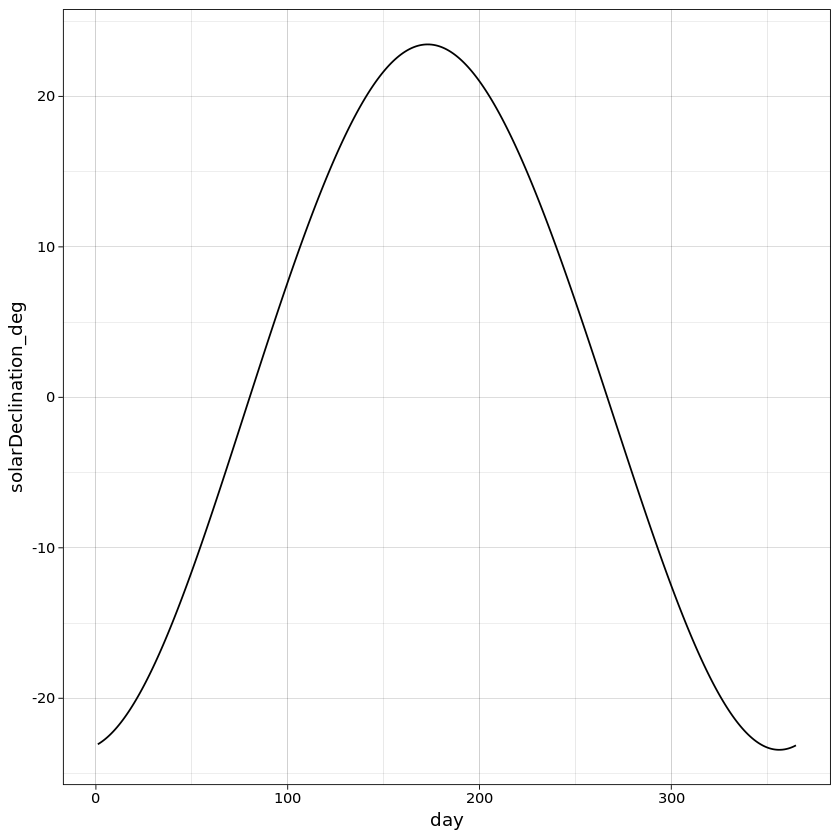

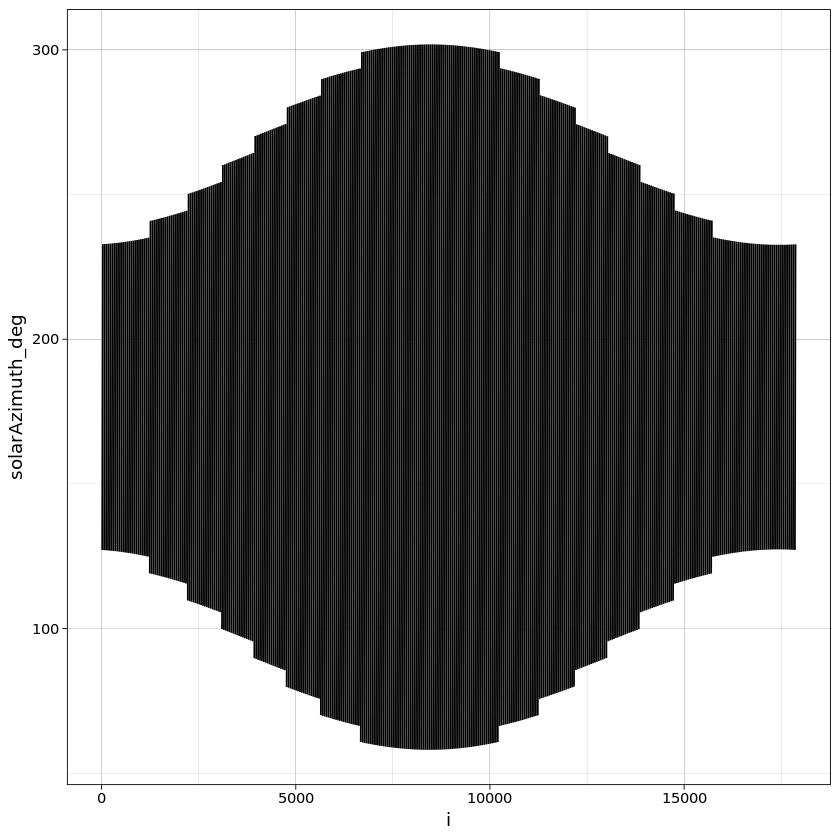

In [12]:
# here you can pick to plot from bigFrame or smallFrame, and which variables you want to compare:
# e.g. smallFrame, x=day, y=solarDeclination_deg
# just change the entries under x and y

# smallFrame plot
ggplot(smallFrame, aes(x=day, y=solarDeclination_deg)) + geom_line() + theme_linedraw()

# bigFrame plot (may be crazy ugly unless you restrict the days you model way at the top)
ggplot(bigFrame, aes(x=i, y=solarAzimuth_deg)) + geom_line() + theme_linedraw()